In [182]:
import skmob
import pandas as pd
from skmob.preprocessing import detection, clustering


def get_week(device_id):
    stdf = skmob.TrajDataFrame.from_file('./staypoint/'+device_id+'/stay_points.csv',
                                         latitude='latitude', longitude='longitude', user_id='deviceid', datetime='arrive_time')
                                         
    stdf.rename(columns={'leaving_time': 'leaving_datetime'}, inplace=True)
    stdf['leaving_datetime'] = pd.to_datetime(stdf['leaving_datetime'])

    weeks = [g for n, g in stdf.set_index('datetime').groupby(pd.Grouper(freq='W'))]
    
    return weeks



# stdf = skmob.TrajDataFrame.from_file('./staypoint/53/stay_points.csv', latitude='latitude', longitude='longitude', user_id='deviceid', datetime='arrive_time')

# stdf.rename(columns={'leaving_time': 'leaving_datetime'}, inplace=True)
# stdf['leaving_datetime'] = pd.to_datetime(stdf['leaving_datetime'])

# print(stdf.head())

# map_f = stdf.plot_trajectory(max_points=1000, start_end_markers=False)
# stdf.plot_stops(map_f=map_f)

In [183]:
# 주단위로 묶어냄
weeks = [g for n, g in stdf.set_index('datetime').groupby(pd.Grouper(freq='W'))]
print(weeks[0].reset_index())
# print(weeks[0])

              datetime  uid        lat         lng    leaving_datetime
0  2019-10-24 02:37:58   53  37.570761  127.034212 2019-10-24 04:42:10
1  2019-10-24 05:09:18   53  37.570762  127.034217 2019-10-24 08:39:30
2  2019-10-24 09:21:04   53  37.560932  127.032245 2019-10-24 10:03:08
3  2019-10-24 10:18:16   53  37.560945  127.032240 2019-10-24 23:21:12
4  2019-10-24 23:25:18   53  37.564035  127.036923 2019-10-25 00:41:02
5  2019-10-25 03:17:50   53  38.076584  127.320265 2019-10-25 04:04:01
6  2019-10-25 05:23:11   53  38.067250  127.325462 2019-10-25 06:27:01
7  2019-10-25 08:53:39   53  37.562298  127.035562 2019-10-25 12:01:18
8  2019-10-25 12:12:30   53  37.560922  127.032230 2019-10-26 08:49:13
9  2019-10-26 08:53:16   53  37.560868  127.038064 2019-10-26 09:27:34
10 2019-10-26 09:27:34   53  37.559276  127.034890 2019-10-26 13:04:57
11 2019-10-26 13:07:01   53  37.560921  127.032232 2019-10-27 04:02:46
12 2019-10-27 05:08:45   53  37.569242  126.978103 2019-10-27 06:03:41
13 201

In [184]:
def get_cluster(weeks):
    cluster_list = []

    for x in weeks:
        if x.empty:
            continue
        cstdf = clustering.cluster(x.reset_index(), cluster_radius_km=0.1, min_samples=1)
        cluster_list.append(cstdf)
    return cluster_list


cluster_list = []

for x in weeks:
    cstdf = clustering.cluster(x.reset_index(), cluster_radius_km=0.1, min_samples=1)
    cluster_list.append(cstdf)
    # print(cstdf.head())

    # cstdf = cstdf.astype({'leaving_datetime': 'datetime64'})
    # cstdf['leaving_datetime'] = pd.to_datetime(cstdf['leaving_datetime'])


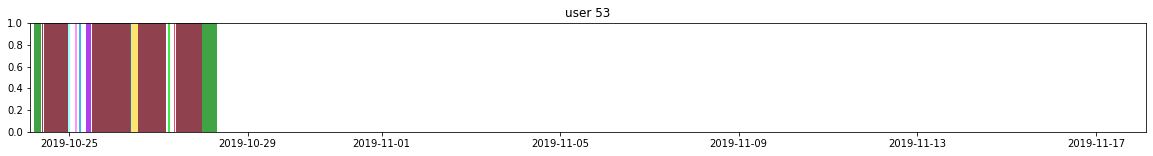

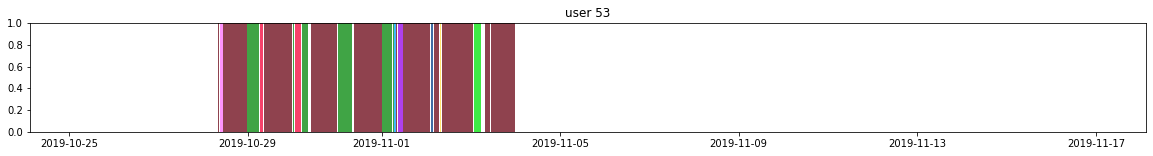

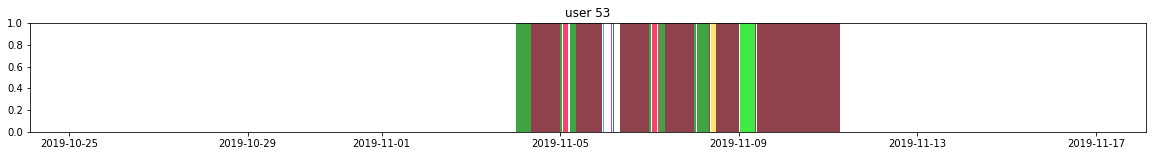

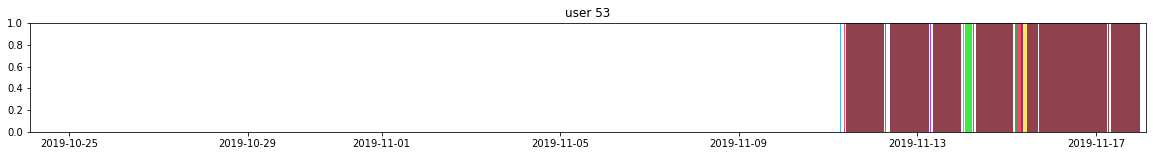

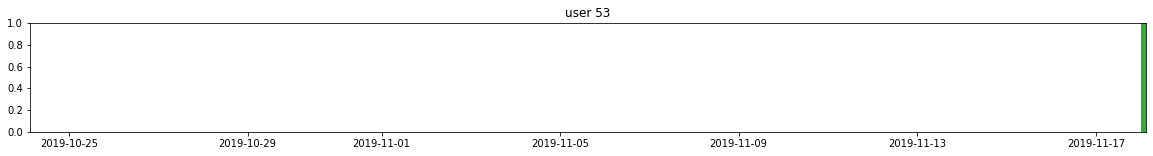

In [185]:
for x in cluster_list:
    user = 53
    start_datetime = pd.to_datetime('2019-10-24 030000')
    end_datetime = pd.to_datetime('2019-11-18 030000')

    ax = x.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

In [186]:
# for x in cluster_list:
#     map_f = stdf.plot_trajectory(max_points=1000, start_end_markers=False)
#     x.plot_stops(map_f=map_f)



# map_f = weeks[0].reset_index().plot_trajectory(max_points=1000, start_end_markers=False)
# cluster_list[0].plot_stops(map_f=map_f)

In [187]:
import json
import os
import sys
import urllib.request

def coords_to_place(x, y):
    client_id = "ktta1uumf3"
    client_secret = "PDFJ27DxqU6bQSsf40GE9DwybUnlgRzZnni42Dqi"
    coords = ','.join([x, y])
    url = "https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords=" + coords + "&sourcecrs=epsg:4326&output=json&orders=roadaddr"
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
    print(f"url: {url}")
    request = urllib.request.Request(url)
    print(f"request: {request}")
    request.add_header("X-NCP-APIGW-API-KEY-ID",client_id)
    request.add_header("X-NCP-APIGW-API-KEY",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        addr_info = response_body.decode('utf-8')
        # print(addr_info)
        addr_info = json.loads(addr_info)
    else:
        print("Error Code:" + rescode)

    if len(addr_info['results']) == 0:
        print(addr_info)
        print(f"x: {x} y: {y}")
        return "none"
    results = addr_info['results'][0]
    land = results['land']
    building_name = land['addition0']['value']
    road_name = land['name']
    number1 = land['number1']
    number2 = land['number2']

    # search = ' '.join([building_name, road_name, number1, number2])
    search = building_name

    # print(f"building name: {building_name} road addr: {road_name} {number1} {number2}")
    # print(search)
    return search

In [188]:
def place_to_category(place):
    print(f"place: {place}")
    if len(place) == 0:
        place = "none"
    client_id = "G3_TXQoFDd0lBFsM8fpG"
    client_secret = "oJaqz0CK0W"
    encText = urllib.parse.quote(place)
    url = "https://openapi.naver.com/v1/search/local?query=" + encText # JSON 결과
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        category_info = response_body.decode('utf-8')
        category_info = json.loads(category_info)
    else:
        print("Error Code:" + rescode)
    
    if len(category_info['items']) == 0:
        return "none"
    item = category_info['items'][0]
    category = item['category']
    # print(category)
    
    return category

In [189]:
# 대표 클러스터 추출
# from unicodedata import category


def get_rep_cluster(cluster_list):
    rep_cluster_list = []
    for df in cluster_list:
        
        idx = df[df['cluster'] == 0].index
        ndf = df.drop(idx)

        if ndf.empty:
            continue
        ndf['year'] = ndf['datetime'].map(lambda x: x.isocalendar()[0])
        ndf['week'] = ndf['datetime'].map(lambda x: x.isocalendar()[1])

        # 평균값을 취해서 cluster별로 좌표 추출
        ndf = ndf.groupby('cluster').mean()
        ndf['year'] = ndf['year'].astype('object')
        ndf['category'] = ''
        # print(ndf)

        for idx in ndf.index:
            x = "{:.7f}".format(ndf.loc[idx, 'lng'])
            y = "{:.7f}".format(ndf.loc[idx, 'lat'])
            # print(f"x: {x} y: {y}")
            place = coords_to_place(x, y)
            category = place_to_category(place)
            ndf.loc[idx, 'category'] = category

        rep_cluster_list.append(ndf)

    return rep_cluster_list





# cluster를 group 별로 묶어내기
# cluster의 크기가 가장 큰 것은 집으로 판단하고 제외함 (가장 큰 cluster는 항상 0번 cluster이므로 0번 cluster를 제외시킴)
temp = cluster_list[2]
idx = temp[temp['cluster'] == 0].index
temp = temp.drop(idx)
# print(temp.groupby('cluster').size())
# print(temp['datetime'][0].isocalendar())
temp['year'] = temp['datetime'].map(lambda x: x.isocalendar()[0])
temp['week'] = temp['datetime'].map(lambda x: x.isocalendar()[1])

# print(temp['year'].dtype)
# print(temp.head())

temp = temp.groupby('cluster').mean()
temp['year'] = temp['year'].astype('object')
print(temp.dtypes)

print(temp.values.tolist())

uid       int64
lat     float64
lng     float64
year     object
week      int64
dtype: object
[[53, 37.57074559285714, 127.03419832857142, 2019, 45], [53, 37.56512313333334, 127.05578851666667, 2019, 45], [53, 37.5207879, 126.9777805, 2019, 45], [53, 37.5623319, 127.0355905, 2019, 45], [53, 37.518007, 127.0715192, 2019, 45], [53, 37.5168406, 127.0703861, 2019, 45], [53, 37.5610911, 127.03651815, 2019, 45]]


In [190]:
import csv, os




# print(os.listdir('./'))


device_id_list = []
for it in os.scandir('./staypoint'):
    if it.is_dir():
        if it.name.isdigit():
            device_id_list.append(it.name)

print(device_id_list)
# device_id_list = ['275']



['61', '95', '59', '104', '103', '331', '150', '51', '58', '93', '94', '60', '397', '151', '216', '211', '218', '274', '273', '287', '210', '217', '228', '272', '275', '401', '268', '250', '266', '261', '260', '258', '251', '256', '174', '173', '142', '129', '116', '118', '87', '80', '172', '81', '86', '110', '322', '128', '88', '395', '65', '136', '62', '96', '100', '54', '107', '98', '138', '53', '393', '394', '99', '52', '139', '108', '63', '64', '270', '212', '271', '213', '209', '207', '253', '254', '402', '262', '265', '208', '264', '263', '255', '403', '252', '79', '112', '318', '115', '83', '123', '141', '328', '85', '317', '125', '319', '113', '147', '140', '149']


In [191]:
for device_id in device_id_list:
        print(device_id)
        fields = ['deviceid', 'latitude', 'longitude', 'year', 'week', 'category']
        path = "./staypoint/" + device_id
        weeks = get_week(device_id)
        cluster_list = get_cluster(weeks)
        represent = get_rep_cluster(cluster_list)

        with open("./staypoint/"+device_id+'/category.csv', 'w',newline='') as f:
            write = csv.writer(f)
            write.writerow(fields)

            for df in represent:
                rep = df.values.tolist()
                # print(rep)
                write.writerows(rep)

61
url: https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords=127.0304874,37.5576075&sourcecrs=epsg:4326&output=json&orders=roadaddr
request: <urllib.request.Request object at 0x7f8539f61a90>
{'status': {'code': 3, 'name': 'no results', 'message': '요청한 데이타의 결과가 없습니다.'}, 'results': []}
x: 127.0304874 y: 37.5576075
place: none
url: https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords=127.0321644,37.5588664&sourcecrs=epsg:4326&output=json&orders=roadaddr
request: <urllib.request.Request object at 0x7f8539f5fbd0>
place: 무학교회
url: https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords=127.0299269,37.5600192&sourcecrs=epsg:4326&output=json&orders=roadaddr
request: <urllib.request.Request object at 0x7f85616ed490>
place: 
url: https://naveropenapi.apigw.ntruss.com/map-reversegeocode/v2/gc?request=coordsToaddr&coords=127.1436571,37.5305233&sourcecrs=epsg:4326&output=json&orders=roadad

In [192]:
# test_search = "성수동1가 655-4"
# temp = place_to_category(test_search)
# print(temp)